In [1]:
from FlagEmbedding import FlagModel
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pprint import pprint as pp
import time
import umap
import os
import random
from datasets import load_dataset, load_from_disk
from datasets import load_dataset, concatenate_datasets, load_from_disk
import pandas as pd
import datasets
from datasets import Dataset
from pprint import pprint as pp
from datasets import Dataset
from sklearn.cluster import KMeans
from tqdm import tqdm
import torch
import heapq

In [2]:
import polars as pl

In [15]:
data = load_dataset("json", data_files="/mnt/bn/data-tns-live-llm/leon/datasets/less-data/train/processed/flan_v2/flan_v2_data.jsonl")["train"]
print(data)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['dataset', 'id', 'messages'],
    num_rows: 100000
})


In [16]:
def get_instruction(example):
    example["instruction"] = example["messages"][0]["content"]
    return example

In [17]:
data = data.map(lambda example: get_instruction(example), batched=False)
print(data)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset({
    features: ['dataset', 'id', 'messages', 'instruction'],
    num_rows: 100000
})


In [18]:
idxs = random.sample(range(len(data)),10000)
tmp = data.select(idxs)

In [19]:
model = FlagModel('BAAI/bge-large-en-v1.5', 
                  query_instruction_for_retrieval="",
                  use_fp16=True)

----------using 8*GPUs----------


Inference Embeddings: 100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


[5 0 6 ... 1 9 0]


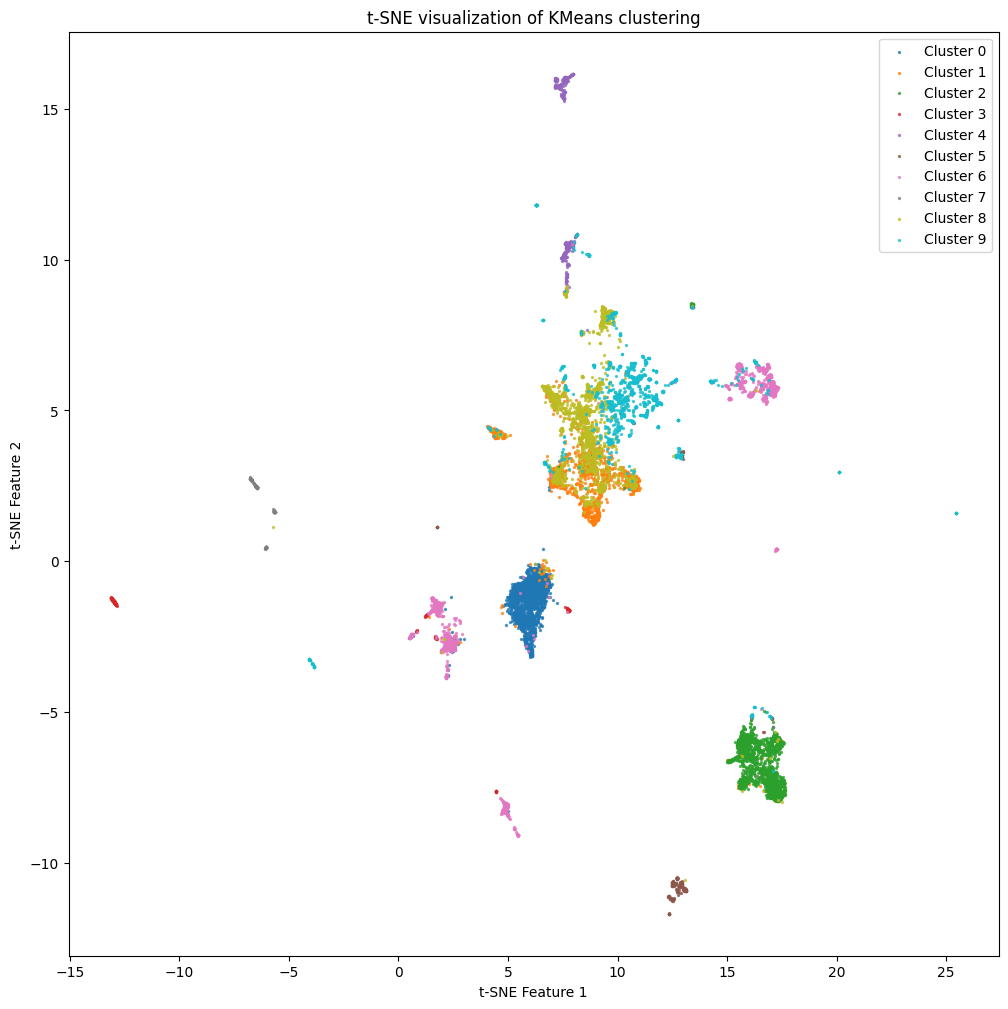

ValueError: Value of 'size' is not the name of a column in 'data_frame'. Expected one of ['UMAP_1', 'UMAP_2', 'UMAP_3', 'Cluster'] but received: 2

In [22]:
k=10
embeddings = model.encode(tmp["instruction"])
# # 假设 embeddings 是你的嵌入数据
kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
labels = kmeans.labels_
print(labels)
# 使用 t-SNE 进行降维
umap_model = umap.UMAP(n_components=2, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)
# 可视化聚类结果
plt.figure(figsize=(12, 12))
for i in range(k):
    # 选择属于当前簇的点
    points = umap_results[labels == i]
    # 绘制这些点，并用不同的颜色进行区分
    plt.scatter(points[:, 0], points[:, 1], label=f'Cluster {i}', s=2, alpha=0.7)

plt.title('t-SNE visualization of KMeans clustering')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

import numpy as np
from sklearn.cluster import KMeans
import umap
import plotly.express as px

# 使用 UMAP 进行降维 (3 维)
umap_model = umap.UMAP(n_components=3, metric='cosine')
umap_results = umap_model.fit_transform(embeddings)

# 创建一个 DataFrame 来保存 UMAP 结果和标签
import pandas as pd

data = pd.DataFrame(umap_results, columns=["UMAP_1", "UMAP_2", "UMAP_3"])
# 添加聚类标签
data['Cluster'] = labels

# 使用 Plotly 进行 3D 可视化
fig = px.scatter_3d(data, x='UMAP_1', y='UMAP_2', z='UMAP_3', color='Cluster', size=2, title='3D UMAP Visualization of KMeans Clustering')

# 显示图形
fig.show()